# Backtesting strategies

## 1.-  SMA crossover example with SPY

https://pmorissette.github.io/bt/examples.html

In [1]:
import bt
import talib

In [2]:
## download some data & calc SMAs
data = bt.get('spy', start='2010-01-01')
sma50 = data.rolling(50).mean()
sma200 = data.rolling(200).mean()

#Here we construct the strategy
## now we need to calculate our target weight DataFrame
# first we will copy the sma200 DataFrame since our weights will have the same structure
tw = sma200.copy()

# set appropriate target weights
tw[sma50 > sma200] = 1.0
tw[sma50 <= sma200] = -1.0

# here we will set the weight to 0 - this is because the sma200 needs 200 data points before
# calculating its first point. Therefore, it will start with a bunch of nulls (NaNs).
tw[sma200.isnull()] = 0.0

In [3]:
#Data return close price of assets
data

,spy
Date,
2010-01-04,89.889206
2010-01-05,90.127159
2010-01-06,90.190613
2010-01-07,90.571350
2010-01-08,90.872719
...,...
2022-01-18,456.489990
2022-01-19,451.750000
2022-01-20,446.750000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3036 entries, 2010-01-04 to 2022-01-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spy     3036 non-null   float64
dtypes: float64(1)
memory usage: 47.4 KB


In [5]:
#This is the strategy with WeightTarget
# WeighTarget will take a DataFrame of target weights that is pre-calculated.
# Target weights: When the 50-day MA will be above the 200-day MA, we will be long (+1 target weight). Conversely, when the 50 is below the 200, we will be short (-1 target weight).
# target weihgts +1 is long and -1 is short
tw

,spy
Date,
2010-01-04,0.0
2010-01-05,0.0
2010-01-06,0.0
2010-01-07,0.0
2010-01-08,0.0
...,...
2022-01-18,1.0
2022-01-19,1.0
2022-01-20,1.0


In [6]:
tw.groupby('spy').size()

spy
-1.0     376
 0.0     199
 1.0    2461
dtype: int64

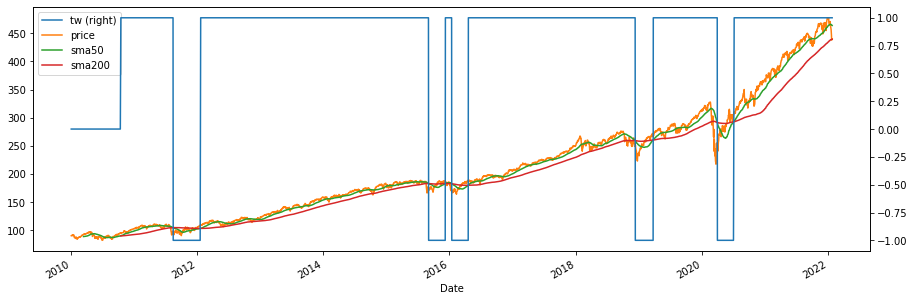

In [7]:
# plot the target weights + chart of price & SMAs
tmp = bt.merge(tw, data, sma50, sma200)
tmp.columns = ['tw', 'price', 'sma50', 'sma200']
ax = tmp.plot(figsize=(15,5), secondary_y=['tw'])

In [8]:
ma_cross = bt.Strategy('ma_cross', [bt.algos.WeighTarget(tw),
                                    bt.algos.Rebalance()])

t = bt.Backtest(ma_cross, data)
res = bt.run(t)

<AxesSubplot:title={'center':'Equity Progression'}>

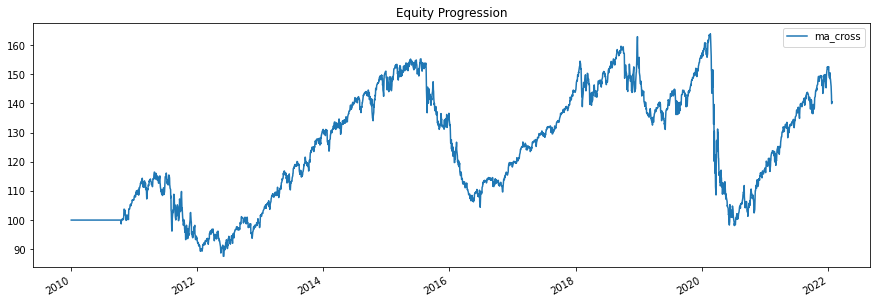

In [9]:
res.plot()

In [10]:
res.display()

Stat                 ma_cross
-------------------  ----------
Start                2010-01-03
End                  2022-01-24
Risk-free rate       0.00%

Total Return         40.51%
Daily Sharpe         0.26
Daily Sortino        0.38
CAGR                 2.86%
Max Drawdown         -40.12%
Calmar Ratio         0.07

MTD                  -7.39%
3m                   -2.59%
6m                   0.65%
YTD                  -7.39%
1Y                   16.40%
3Y (ann.)            -0.83%
5Y (ann.)            3.15%
10Y (ann.)           4.62%
Since Incep. (ann.)  2.86%

Daily Sharpe         0.26
Daily Sortino        0.38
Daily Mean (ann.)    4.15%
Daily Vol (ann.)     16.24%
Daily Skew           -0.75
Daily Kurt           15.58
Best Day             9.06%
Worst Day            -10.94%

Monthly Sharpe       0.28
Monthly Sortino      0.41
Monthly Mean (ann.)  3.80%
Monthly Vol (ann.)   13.74%
Monthly Skew         -0.91
Monthly Kurt         1.46
Best Month           10.88%
Worst Month          -12.49%

## 2. BTC EMA backtesting strategies

In [11]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt

### Extract data from exchange

In [12]:
def read_from_exchange(symbol: str) -> pd.DataFrame:
    """Extract candlestick data from Binance"""
    
    url_base = "https://api.binance.com/"
    url_endpoint = "api/v3/klines"
    binance_candlesticks = requests.get(url_base + url_endpoint + "?symbol={}USDT&interval=1d&limit=800".format(symbol))
    candlestick_info = binance_candlesticks.json()
    
    #Transform into Pandas dataframe to easy manipulation
    df = pd.DataFrame(candlestick_info)
    
    #changing column names
    df.columns = ["Opentime", "Open", "High", "Low", "Close", "Volume", "CloseTime", "QuoteAssetVolume", "NumberOfTrades", "TakerBuyBaseAssetVolume", "TakerBuyQuoteAssetVolume", "Ignore"]
    
    #changing types, objects to float, and unixtimestamp to timestamp
    df['Opentime'] = pd.to_datetime(df['Opentime'], unit='ms', dayfirst=True, origin= "unix")
    df['CloseTime'] = pd.to_datetime(df['CloseTime'], unit='ms', dayfirst=True, origin= "unix")
    df = df.astype({'Open':'float', 'High': 'float', 'Low': 'float', 'Close': 'float', 'Volume': 'float', 'QuoteAssetVolume': 'float64', 'TakerBuyBaseAssetVolume': 'float64', 'TakerBuyQuoteAssetVolume':'float64'})
    
    #setting date as index
    df = df.set_index("Opentime")
    
    return df

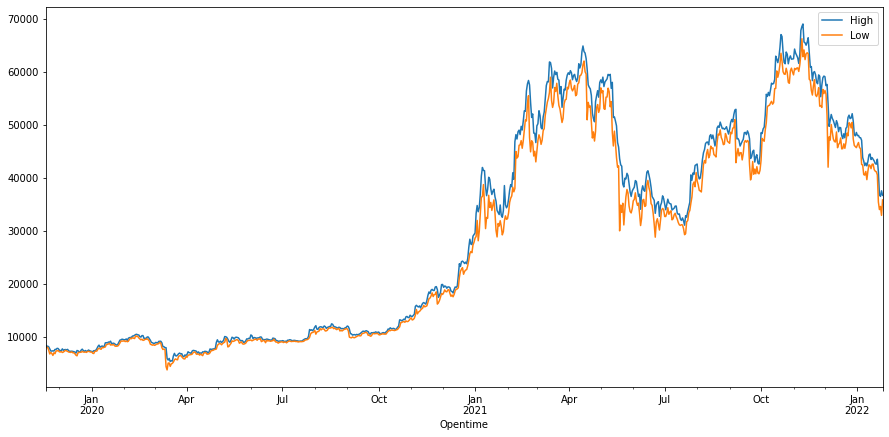

In [13]:
price_data = read_from_exchange('BTC')
price_data[['High', 'Low']].plot(figsize=(15, 7))
plt.show()

In [14]:
price_data.head()

,Open,High,Low,Close,Volume,CloseTime,QuoteAssetVolume,NumberOfTrades,TakerBuyBaseAssetVolume,TakerBuyQuoteAssetVolume,Ignore
Opentime,,,,,,,,,,,
2019-11-18,8502.87,8503.52,8060.0,8187.17,43017.690940,2019-11-18 23:59:59.999,3.587062e+08,366263,20525.116924,1.712560e+08,0
2019-11-19,8186.50,8218.63,8003.0,8133.64,43556.061025,2019-11-19 23:59:59.999,3.534638e+08,357382,21816.725084,1.770616e+08,0
2019-11-20,8133.83,8264.29,8038.4,8098.01,32466.230980,2019-11-20 23:59:59.999,2.633876e+08,288843,16751.186459,1.359137e+08,0
2019-11-21,8098.56,8134.73,7500.0,7627.74,58418.780261,2019-11-21 23:59:59.999,4.551667e+08,430062,26902.369851,2.096693e+08,0
2019-11-22,7627.79,7750.00,6790.0,7268.23,126603.140259,2019-11-22 23:59:59.999,9.178815e+08,817604,60867.912182,4.413692e+08,0


In [15]:
#For backtesting we only need close price
price_data = price_data.loc[:, ['Close']]
price_data

,Close
Opentime,
2019-11-18,8187.17
2019-11-19,8133.64
2019-11-20,8098.01
2019-11-21,7627.74
2019-11-22,7268.23
...,...
2022-01-21,36445.31
2022-01-22,35071.42
2022-01-23,36244.55


### EMA crossover Strategy

In [16]:
#Here talib.EMA changes the column name (this causes problems with backtesting) be Careful Robert!!

#Calculate the indicators
EMA_20 = talib.EMA(price_data['Close'], timeperiod=20).to_frame()
#*probe with ema 50
EMA_50 = talib.EMA(price_data['Close'], timeperiod=50).to_frame()
EMA_100 = talib.EMA(price_data['Close'], timeperiod=100).to_frame()

#Rename columns to Close, if not backstesting will be in trouble
EMA_20.columns = ['Close']
EMA_50.columns = ['Close']
EMA_100.columns = ['Close']

In [17]:
#Construct the signal (Weight targets)

#Create the signal dataframe
signal = EMA_50.copy()
signal[EMA_50.isnull()] = 0

#Construct the signal
signal[EMA_20> EMA_50] = 1
signal[EMA_20 <= EMA_50] = -1
signal

,Close
Opentime,
2019-11-18,0.0
2019-11-19,0.0
2019-11-20,0.0
2019-11-21,0.0
2019-11-22,0.0
...,...
2022-01-21,-1.0
2022-01-22,-1.0
2022-01-23,-1.0


<AxesSubplot:xlabel='Opentime'>

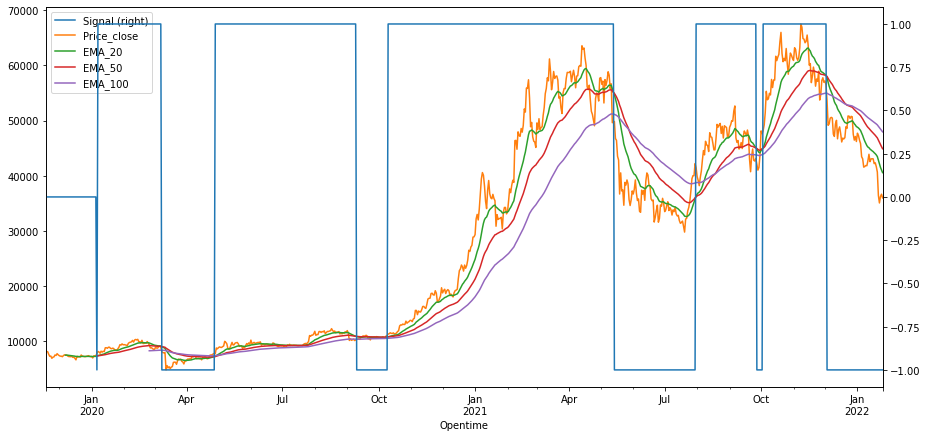

In [19]:
#Combined datafrme
combined_df = bt.merge(signal, price_data, EMA_20, EMA_50, EMA_100)

#Plot the signal, price and MA
#combined_df = bt.merge(signal, price_data, EMA_short, EMA_long)
combined_df.columns = ['Signal', 'Price_close', 'EMA_20', 'EMA_50', 'EMA_100']
combined_df.plot(secondary_y = ['Signal'], figsize=(15, 7))

In [20]:
combined_df.fillna(value = 0, inplace = True)
combined_df.head()

,Signal,Price_close,EMA_20,EMA_50,EMA_100
Opentime,,,,,
2019-11-18,0.0,8187.17,0.0,0.0,0.0
2019-11-19,0.0,8133.64,0.0,0.0,0.0
2019-11-20,0.0,8098.01,0.0,0.0,0.0
2019-11-21,0.0,7627.74,0.0,0.0,0.0
2019-11-22,0.0,7268.23,0.0,0.0,0.0


In [23]:
#Define Strategy
ma_cross = bt.Strategy('EMA_crossover',
                         [bt.algos.WeighTarget(signal),
                         bt.algos.Rebalance()])

In [24]:
#Create the Backtest and run it
bt_backtest = bt.Backtest(ma_cross, price_data)
bt_result = bt.run(bt_backtest)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


<AxesSubplot:title={'center':'Equity Progression'}>

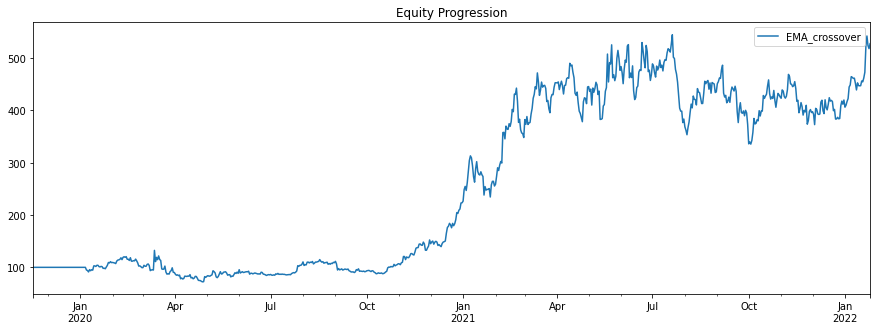

In [25]:
bt_result.plot()

In [26]:
bt_result.display()

Stat                 EMA_crossover
-------------------  ---------------
Start                2019-11-17
End                  2022-01-25
Risk-free rate       0.00%

Total Return         427.77%
Daily Sharpe         1.14
Daily Sortino        2.06
CAGR                 113.72%
Max Drawdown         -45.45%
Calmar Ratio         2.50

MTD                  25.66%
3m                   20.40%
6m                   16.20%
YTD                  25.66%
1Y                   111.89%
3Y (ann.)            113.72%
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  113.72%

Daily Sharpe         1.14
Daily Sortino        2.06
Daily Mean (ann.)    71.54%
Daily Vol (ann.)     62.59%
Daily Skew           1.23
Daily Kurt           14.03
Best Day             39.65%
Worst Day            -16.22%

Monthly Sharpe       1.55
Monthly Sortino      4.89
Monthly Mean (ann.)  95.75%
Monthly Vol (ann.)   61.97%
Monthly Skew         0.59
Monthly Kurt         -0.37
Best Month           46.63%
Worst Month     

In [25]:
#Result 1

#Signal:
#signal[EMA_20> EMA_100] = 1
#signal[EMA_20 <= EMA_100] = -1

#total return = 42% (This is very low)

## 3. Using the Tree Structure (Sub strategies)

In [27]:
#test a strategy that allocated capital to sub-strategies

def ma_cross(ticker: str, short_ma=20, long_ma=50, name='ma_cross'):
    # these are all the same steps as above
    data = read_from_exchange(ticker)
    data = data.loc[:, ['Close']].copy()
    data.columns = [ticker]
    
    short_sma = data.rolling(short_ma).mean()
    long_sma  = data.rolling(long_ma).mean()

    # target weights, i.e strategy
    tw = long_sma.copy()
    tw[short_sma > long_sma] = 1.0
    tw[short_sma <= long_sma] = -1.0
    tw[long_sma.isnull()] = 0.0

    # here we specify the children (3rd) arguemnt to make sure the strategy
    # has the proper universe. This is necessary in strategies of strategies
    s = bt.Strategy(name, [bt.algos.WeighTarget(tw), bt.algos.Rebalance()], [ticker])

    return bt.Backtest(s, data)

#if __name__ == "__main__":
#    ma_cross('BTC')

In [31]:
# ok now let's create a few backtests and gather the results.
# these will later become our "synthetic securities"
t1 = ma_cross('BTC', name='BTC_ma_cross')
t2 = ma_cross('ETH', name='ETH_ma_cross')

# let's run these strategies now
res = bt.run(t1, t2)

# now that we have run the strategies, let's extract
# the data to create "synthetic securities"
data = bt.merge(res['BTC_ma_cross'].prices, res['ETH_ma_cross'].prices)

# now we have our new data. This data is basically the equity
# curves of both backtested strategies. Now we can just use this
# to test any old strategy, just like before.
s = bt.Strategy('s', [bt.algos.SelectAll(),
                      bt.algos.WeighInvVol(),
                      bt.algos.Rebalance()])

# create and run
t = bt.Backtest(s, data)
res_merged = bt.run(t)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python

<AxesSubplot:title={'center':'Equity Progression'}>

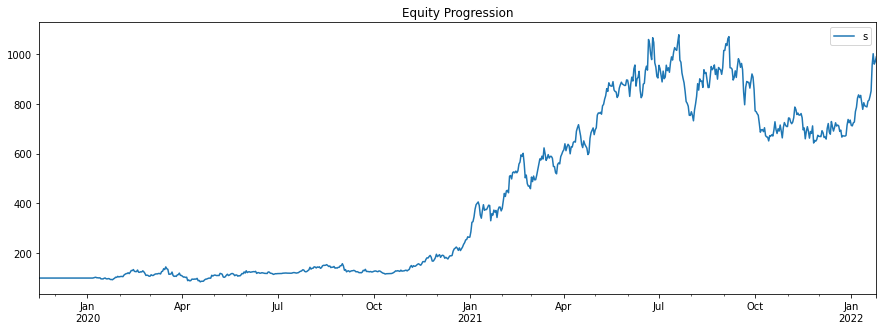

In [32]:
res_merged.plot()

In [33]:
res.display()

Stat                 BTC_ma_cross    ETH_ma_cross
-------------------  --------------  --------------
Start                2019-11-17      2019-11-17
End                  2022-01-25      2022-01-25
Risk-free rate       0.00%           0.00%

Total Return         443.42%         684.23%
Daily Sharpe         1.16            1.21
Daily Sortino        2.09            1.95
CAGR                 116.59%         156.08%
Max Drawdown         -48.45%         -71.17%
Calmar Ratio         2.41            2.19

MTD                  25.60%          46.31%
3m                   24.65%          54.84%
6m                   2.41%           18.32%
YTD                  25.60%          46.31%
1Y                   118.24%         148.86%
3Y (ann.)            116.59%         156.08%
5Y (ann.)            -               -
10Y (ann.)           -               -
Since Incep. (ann.)  116.59%         156.08%

Daily Sharpe         1.16            1.21
Daily Sortino        2.09            1.95
Daily Mean (ann.)    7

In [34]:
res_merged.display()

Stat                 s
-------------------  ----------
Start                2019-11-16
End                  2022-01-25
Risk-free rate       0.00%

Total Return         889.29%
Daily Sharpe         1.55
Daily Sortino        2.63
CAGR                 184.35%
Max Drawdown         -41.45%
Calmar Ratio         4.45

MTD                  34.62%
3m                   38.35%
6m                   11.82%
YTD                  34.62%
1Y                   171.12%
3Y (ann.)            184.35%
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  184.35%

Daily Sharpe         1.55
Daily Sortino        2.63
Daily Mean (ann.)    88.50%
Daily Vol (ann.)     57.03%
Daily Skew           -0.15
Daily Kurt           2.21
Best Day             15.07%
Worst Day            -15.65%

Monthly Sharpe       2.00
Monthly Sortino      6.59
Monthly Mean (ann.)  128.17%
Monthly Vol (ann.)   64.23%
Monthly Skew         0.39
Monthly Kurt         -0.66
Best Month           49.81%
Worst Month          -17.37%

Ye

## Tree Structrure Example: Aapl and msft

In [35]:
# first let's create a helper function to create a ma cross backtest
def ma_cross(ticker, start='2010-01-01',
             short_ma=50, long_ma=200, name='ma_cross'):
    # these are all the same steps as above
    data = bt.get(ticker, start=start)
    short_sma = data.rolling(short_ma).mean()
    long_sma  = data.rolling(long_ma).mean()

    # target weights
    tw = long_sma.copy()
    tw[short_sma > long_sma] = 1.0
    tw[short_sma <= long_sma] = -1.0
    tw[long_sma.isnull()] = 0.0

    # here we specify the children (3rd) arguemnt to make sure the strategy
    # has the proper universe. This is necessary in strategies of strategies
    s = bt.Strategy(name, [bt.algos.WeighTarget(tw), bt.algos.Rebalance()], [ticker])

    return bt.Backtest(s, data)

# ok now let's create a few backtests and gather the results.
# these will later become our "synthetic securities"
t1 = ma_cross('aapl', name='aapl_ma_cross')
t2 = ma_cross('msft', name='msft_ma_cross')

# let's run these strategies now
res_stocks = bt.run(t1, t2)

# now that we have run the strategies, let's extract
# the data to create "synthetic securities"
data = bt.merge(res_stocks['aapl_ma_cross'].prices, res_stocks['msft_ma_cross'].prices)

# now we have our new data. This data is basically the equity
# curves of both backtested strategies. Now we can just use this
# to test any old strategy, just like before.
s = bt.Strategy('s', [bt.algos.SelectAll(),
                      bt.algos.WeighInvVol(),
                      bt.algos.Rebalance()])

# create and run
t = bt.Backtest(s, data)
res_stocks_merged = bt.run(t)

<AxesSubplot:title={'center':'Equity Progression'}>

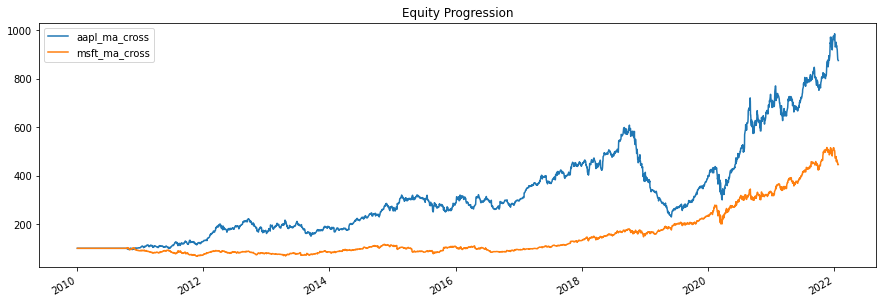

In [36]:
res_stocks.plot()

<AxesSubplot:title={'center':'Equity Progression'}>

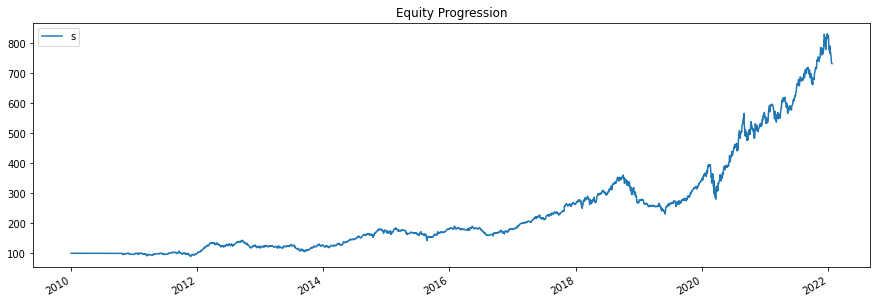

In [37]:
res_stocks_merged.plot()

In [38]:
res_stocks_merged.display()

Stat                 s
-------------------  ----------
Start                2010-01-02
End                  2022-01-24
Risk-free rate       0.00%

Total Return         632.42%
Daily Sharpe         0.89
Daily Sortino        1.43
CAGR                 17.95%
Max Drawdown         -36.10%
Calmar Ratio         0.50

MTD                  -10.49%
3m                   2.30%
6m                   6.49%
YTD                  -10.49%
1Y                   27.20%
3Y (ann.)            37.73%
5Y (ann.)            31.76%
10Y (ann.)           21.29%
Since Incep. (ann.)  17.95%

Daily Sharpe         0.89
Daily Sortino        1.43
Daily Mean (ann.)    18.73%
Daily Vol (ann.)     20.97%
Daily Skew           -0.17
Daily Kurt           12.44
Best Day             13.14%
Worst Day            -13.81%

Monthly Sharpe       0.96
Monthly Sortino      1.92
Monthly Mean (ann.)  18.56%
Monthly Vol (ann.)   19.41%
Monthly Skew         -0.04
Monthly Kurt         0.08
Best Month           15.66%
Worst Month          -13.8